In [12]:
from system import *
from math import floor
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as color

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

plt.rcParams.update({'font.size': 18})

e_field = zero_field()
b_field = t89(7)
system  = System(e_field, b_field)

In [13]:
system.load("EQ_5000_10_1e6_1-90_0-360")

Loaded files containing 916.10 megabytes of information.


In [14]:
@njit
def lost_ind(history):
    num_particles = len(history[:, 0, 0, 0])
    steps         = len(history[0, :, 0, 0])
    
    zero_array = np.zeros((4, 3))
    index_list = np.zeros(num_particles) + steps

    for i in range(num_particles):
        for j in range(steps):
            if (history[i, -(j + 1), :, :] == zero_array).all():
                index_list[i] -= 1
            else:
                break

    return index_list

ind_list = lost_ind(system.history)

In [16]:
len(np.argwhere(ind_list < 2000))

10

In [6]:
@njit
def per_particle_mu_diffusion(history, intrinsic, delta_t, dt):
    num_particles    = len(history[:, 0, 0, 0])
    delta_t_ind      = int(delta_t / dt)
    steps            = int(len(history[0, :, 0, 0]) / delta_t_ind)
    indices          = np.arange(0, steps) * dt
    
    mom = magnetic_moment(history, intrinsic)
    b   = history[:, :, 2, :]
    bm  = b_mag(history)
    v   = history[:, :, 1, :]

    mus   = np.zeros((num_particles, steps - 1))
    D_uus = np.zeros((num_particles, steps - 1))
    t_coef = np.zeros((num_particles, steps - 1))
    
    for i in range(num_particles):
        b_min = np.amin(bm[i, 0:ind_list[i]])
        
        for j in range(steps - 1): 
            if (j + 1) * delta_t_ind >= ind_list[i]:
                break
                
            mu_begin = mom[i, j * delta_t_ind] * b_min / (intrinsic[i, 0] * dot(v[i, j * delta_t_ind], v[i, j * delta_t_ind]))
            mu_end = mom[i, (j + 1) * delta_t_ind] * b_min / (intrinsic[i, 0] * dot(v[i, (j + 1) * delta_t_ind], v[i, (j + 1) * delta_t_ind]))
            D_uus[i, j] = (mu_end - mu_begin)**2 / (2 * delta_t)
            
            mus[i, j]   = np.degrees(np.arcsin(np.sqrt(2 * mu_begin)))
            if dot(v[i, j * delta_t_ind], b[i, j * delta_t_ind]) < 0:
                mus[i, j] = 180.0 - mus[i, j]
            
            temp_end = np.degrees(np.arcsin(np.sqrt(2 * mu_end)))
            if dot(v[i, (j + 1) * delta_t_ind], b[i, (j + 1) * delta_t_ind]) < 0:
                temp_end = 180.0 - temp_end
            
            t_coef[i, j] = temp_end - mus[i, j]
            
    return mus, D_uus, t_coef

In [5]:
@njit
def eq_pa_from_mu(history, intrinsic, b_min):
    num_particles = len(history[:, 0, 0, 0])
    steps = len(history[0, :, 0, 0])

    bm  = b_mag(history)
    pa  = np.radians(pitch_angle(history))
    
    history_new = np.zeros((num_particles, steps))

    for i in range(num_particles):
        for j in range(steps):
            history_new[i, j] = np.arcsin(np.sqrt(b_min / bm[i, j]) * np.sin(pa[i, j]))
            
    return np.degrees(history_new)

In [9]:
def D_mumu_evolution(history, h_bins, v_bins, T, dt):
    delta_t = T / h_bins
    mus, D_uus, t_coef = per_particle_mu_diffusion(system.history, system.ics[:, 4, 0:2], delta_t, 1e-3)

    D_uu_map = np.zeros((v_bins, h_bins))
    t_coef_map = np.zeros((v_bins, h_bins))

    for i in range(h_bins - 1):
        D_uu_averaged = [[] for k in range(v_bins)]
        t_coef_averaged = [[] for k in range(v_bins)]
        
        bin_size = 180.0 / v_bins
        
        for j in range(len(mus[:, i])):
            bin_ind = floor(mus[j, i] // bin_size)
            if bin_ind == v_bins:
                bin_ind -= 1
            D_uu_averaged[bin_ind].append(D_uus[j, i])
            t_coef_averaged[bin_ind].append(t_coef[j, i])

        for k, d in enumerate(D_uu_averaged):
            if len(d) == 0:
                D_uu_averaged[k].append(0)
        
        for k, d in enumerate(t_coef_averaged):
            if len(d) == 0:
                t_coef_averaged[k].append(0)

        D_uu_map[:, i] = np.flip(np.array([np.mean(k) for k in D_uu_averaged]))
        t_coef_map[:, i] = np.flip(np.array([np.mean(k) for k in t_coef_averaged]))

    
    col = plt.cm.plasma(0.2)
    
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['font.family'] = 'Liberation Sans'
    
    fig = plt.figure(figsize=(12, 4.8))
    
    plt.subplot(1, 2, 1)
    im = plt.gca().imshow(D_uu_map, cmap='plasma', norm=color.LogNorm(vmin=1e-4, vmax=1))

    plt.xticks(np.linspace(0, h_bins, 5), [f'{k:.2f}' for k in np.linspace(0, T, 5)])
    plt.yticks(np.linspace(0, v_bins, 5), [f'{k:.2f}' for k in np.linspace(180, 0, 5)])
    
    plt.xlabel('Time (s)')
    plt.ylabel(r'Eq. pitch angle $\alpha_0^\circ$')
    plt.title(r'Diffusion coef.')
    
    cbar = plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(r'$D_{\alpha_0\alpha_0}(\alpha_0)$', rotation=-90, va="bottom")
    
    plt.subplot(1, 2, 2)
    plt.xlim([0, 180])
    plt.xticks(np.linspace(0, 180, 5))
    plt.xlabel(r'Eq. pitch angle $\alpha_0^\circ$')
    
    plt.ylim([1e-4, 1])
    plt.yticks(np.logspace(-8, 0, 5))
    plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}(\alpha_0) \rangle$')

    plt.grid(True)
    plt.gca().xaxis.grid(True)

    plt.semilogy(np.linspace(0, 180, v_bins), np.flip(np.mean(D_uu_map[:, -int(v_bins/3):], axis=1)), color='black')
    [i.set_color('black') for i in plt.gca().get_yticklabels()]
    
    ax = plt.gca().twinx()
    ax.plot(np.linspace(0, 180, v_bins), np.flip(np.mean(t_coef_map[:, -int(v_bins/3):], axis=1)), color=col)
    
    plt.ylim([-20, 20])
    plt.yticks(np.linspace(-40, 40, 5))
    plt.ylabel(r'$\langle\Delta\alpha_0\rangle$ (deg)', color=col)
    [i.set_color(col) for i in ax.get_yticklabels()]
    
    plt.title(r'Time average')
    
    plt.tight_layout(pad=2.0)
    plt.show()

In [3]:
@njit
def per_particle_diffusion(history, delta_t, dt):
    num_particles    = len(history[:, 0, 0, 0])
    delta_t_ind      = int(delta_t / dt)
    steps            = int(len(history[0, :, 0, 0]) / delta_t_ind)
    v                = velocity(history)
    indices          = np.arange(0, steps) * dt

    mus    = np.zeros((num_particles, steps - 1))
    D_uus  = np.zeros((num_particles, steps - 1))
    t_coef = np.zeros((num_particles, steps - 1))

    for i in range(num_particles):
        for j in range(steps - 1):
            v_par_mag_beg   = dot(v[i, j * delta_t_ind], history[i, j * delta_t_ind, 2, :]) / np.linalg.norm(history[i, j * delta_t_ind, 2, :])
            v_par_mag_end   = dot(v[i, (j + 1) * delta_t_ind], history[i, (j + 1) * delta_t_ind, 2, :]) / np.linalg.norm(history[i, (j + 1) * delta_t_ind, 2, :])
            
            mu_begin    = v_par_mag_beg / np.linalg.norm(v[i, j * delta_t_ind])
            mu_end      = v_par_mag_end / np.linalg.norm(v[i, (j + 1) * delta_t_ind])
            D_uus[i, j] = (mu_end - mu_begin)**2 / (2 * delta_t)
            mus[i, j]   = mu_begin
            t_coef[i, j] = mu_begin - mu_end
            
    return mus, D_uus, t_coef

def D_uu_evolution(history, h_bins, v_bins, T, dt):
    delta_t = T / h_bins
    mus, D_uus, t_coef = per_particle_diffusion(history, delta_t, 1e-3)

    D_uu_map = np.zeros((v_bins, h_bins))
    t_coef_map = np.zeros((v_bins, h_bins))

    for i in range(h_bins - 1):
        D_uu_averaged = [[] for k in range(v_bins)]
        t_coef_averaged = [[] for k in range(v_bins)]

        bin_size = 2.0 / v_bins

        for j in range(len(mus[:, i])):
            bin_ind = floor((mus[j, i] + 1) // bin_size)
            D_uu_averaged[bin_ind].append(D_uus[j, i])
            t_coef_averaged[bin_ind].append(t_coef[j, i])

        for k, d in enumerate(D_uu_averaged):
            if len(d) == 0:
                D_uu_averaged[k].append(0)
                
        for k, d in enumerate(t_coef_averaged):
            if len(d) == 0:
                t_coef_averaged[k].append(0)
                
        D_uu_map[:, i] = np.flip(np.array([np.mean(k) for k in D_uu_averaged]))
        t_coef_map[:, i] = np.flip(np.array([np.mean(k) for k in t_coef_averaged]))
    
    fig = plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    im = plt.gca().imshow(D_uu_map, cmap='plasma')

    plt.xticks(np.linspace(0, h_bins, 5), [f'{k:.2f}' for k in np.linspace(0, T, 5)])
    plt.yticks(np.linspace(0, v_bins, 5), [f'{k:.2f}' for k in np.linspace(1, -1, 5)])
    
    plt.xlabel('Time (s)')
    plt.ylabel(r'$\mu = v_{\parallel}/v$')
    plt.title(r'Evolution of $D_{\mu\mu}(\mu)$')
    
    plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)
    
    plt.subplot(1, 2, 2)
    plt.xlim([-1, 1])
    plt.xticks(np.linspace(-1, 1, 5))
    plt.xlabel(r'$\mu = v_{\parallel}/v$')
    
    plt.ylim([0, 40])
    plt.yticks(np.linspace(0, 40, 5))
    plt.ylabel(r'$D_{\mu\mu}(\mu)$')

    plt.grid(True)
    plt.gca().xaxis.grid(True)

    plt.plot(np.linspace(-1, 1, v_bins), np.flip(np.mean(D_uu_map[:, -int(v_bins/3):], axis=1)), color='black')
    [i.set_color('black') for i in plt.gca().get_yticklabels()]
    
    ax = plt.gca().twinx()
    ax.plot(np.linspace(-1, 1, v_bins), np.flip(np.mean(t_coef_map[:, -int(v_bins/3):], axis=1)), color='tab:red')
    
    plt.ylim([-20, 20])
    plt.yticks(np.linspace(-40, 40, 5))
    plt.ylabel(r'$\langle\Delta\mu\rangle$', color='tab:red')
    [i.set_color('tab:red') for i in ax.get_yticklabels()]
    
    plt.title(r'Diffusion and transport coefs.')
    
    plt.tight_layout(pad=2.0)
    plt.show()

In [4]:
system.populate_by_eq_pa(1000,
                         delta(10),
                         delta(1e6),
                         uniform(np.radians(1), np.radians(90)),
                         uniform(0, 2 * np.pi)
                        )

100%|██████████| 1000/1000 [00:02<00:00, 430.59it/s]


In [5]:
system.solve(2, 1e-4)

100%|██████████| 1000/1000 [01:07<00:00, 14.82it/s]


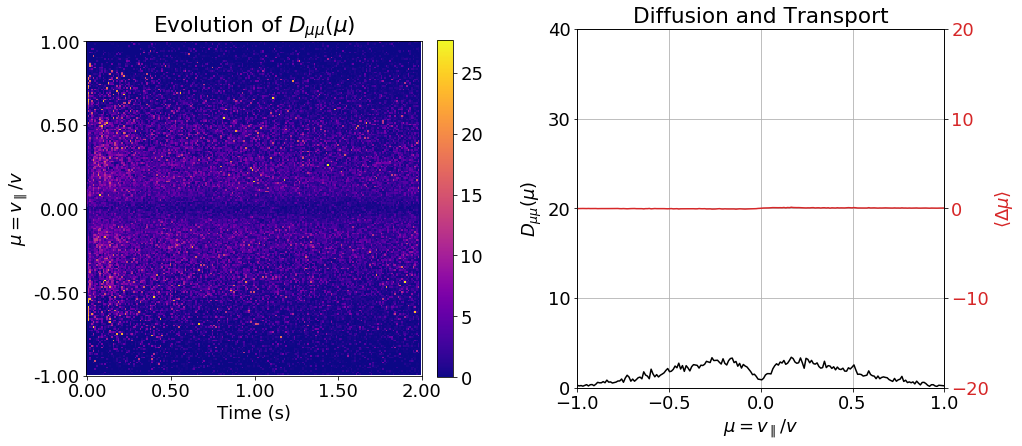

In [8]:
D_uu_evolution(system.history, 200, 200, 2, 1e-3)

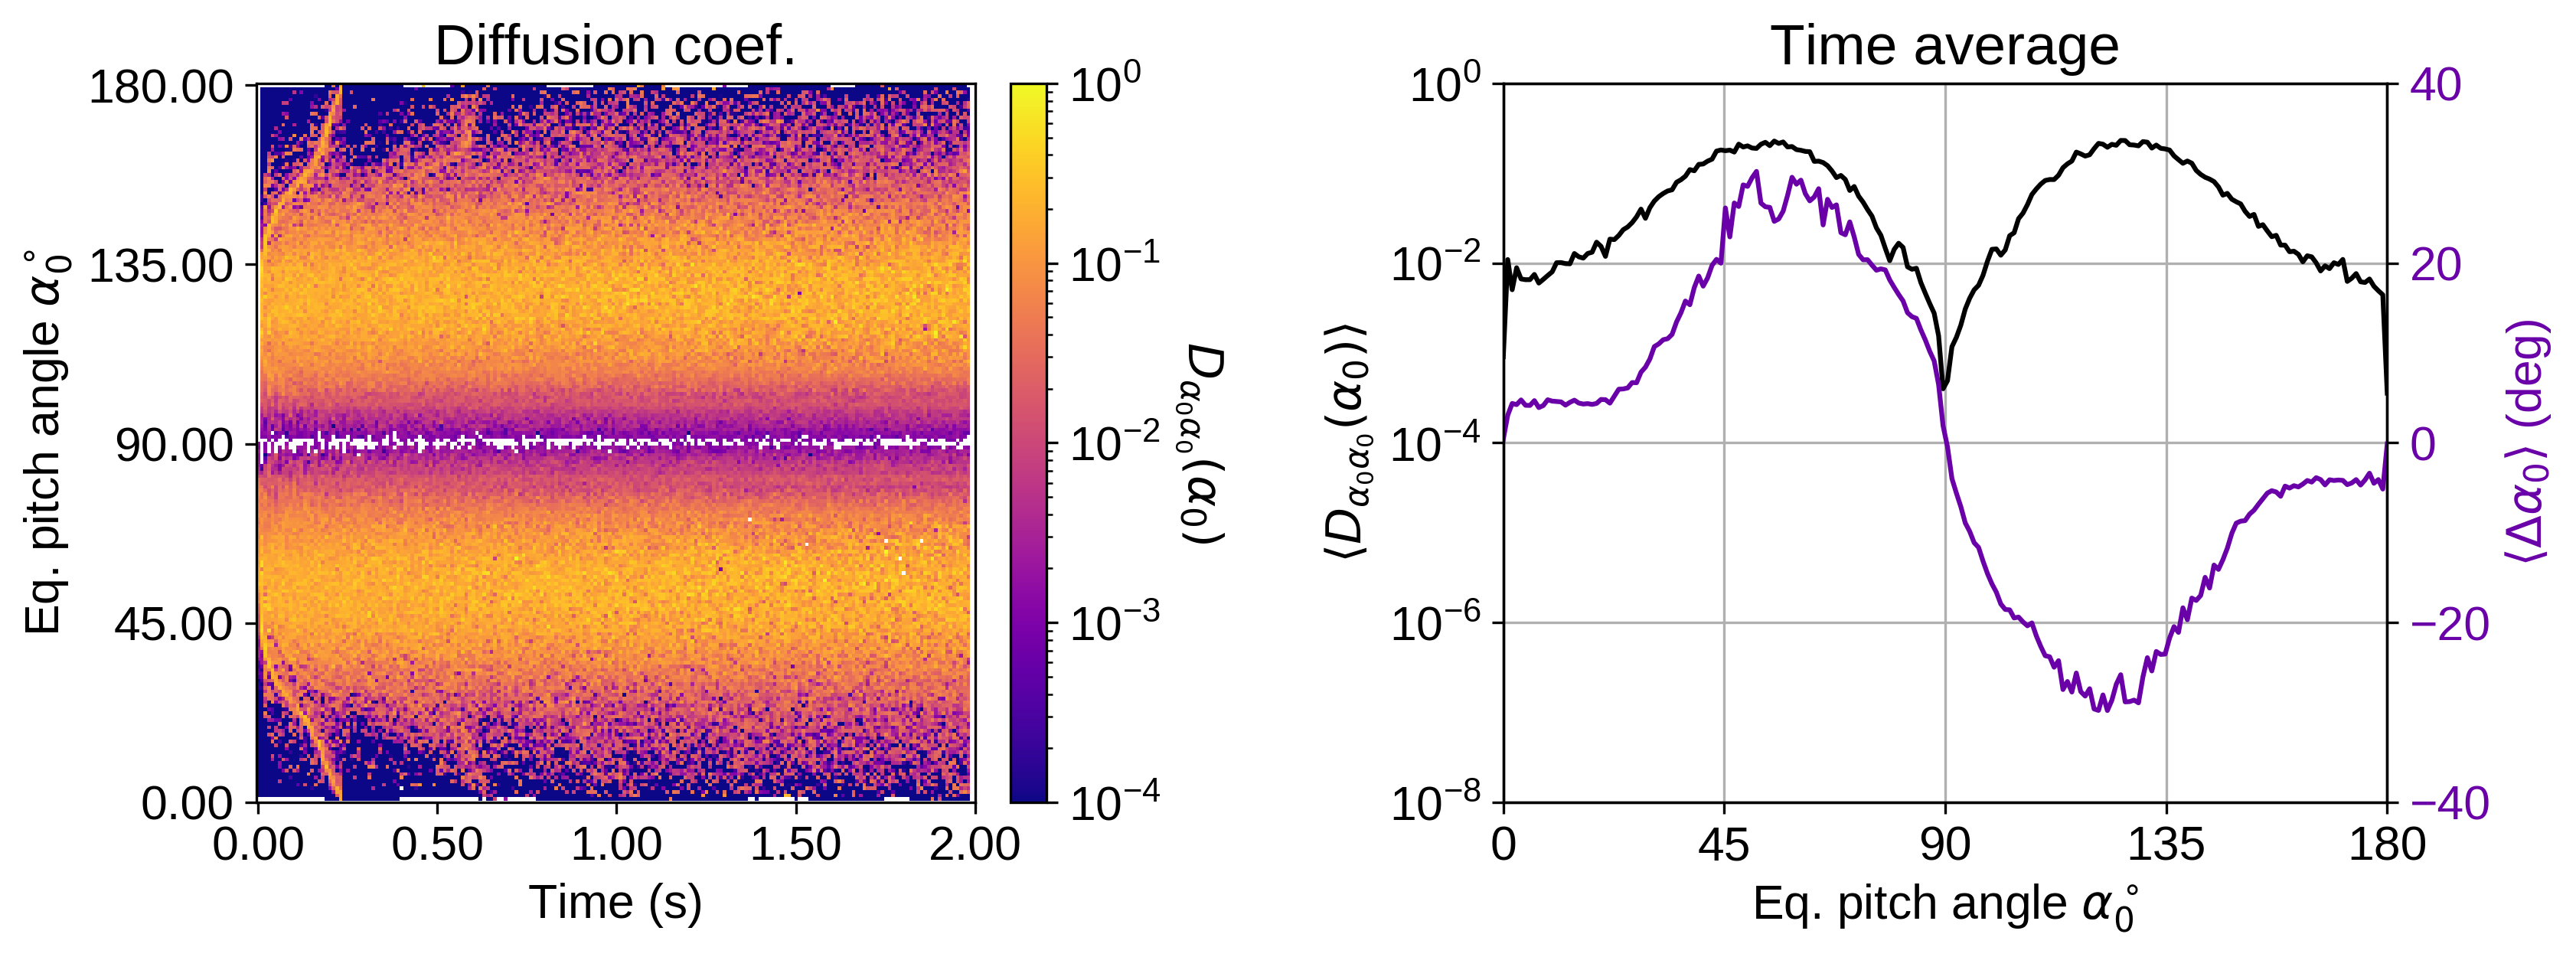

In [10]:
D_mumu_evolution(system.history, 200, 200, 2, 1e-3)

In [8]:
system.load("5000_12Re_1MeV_uniform")

Loaded files containing 916.10 megabytes of information.


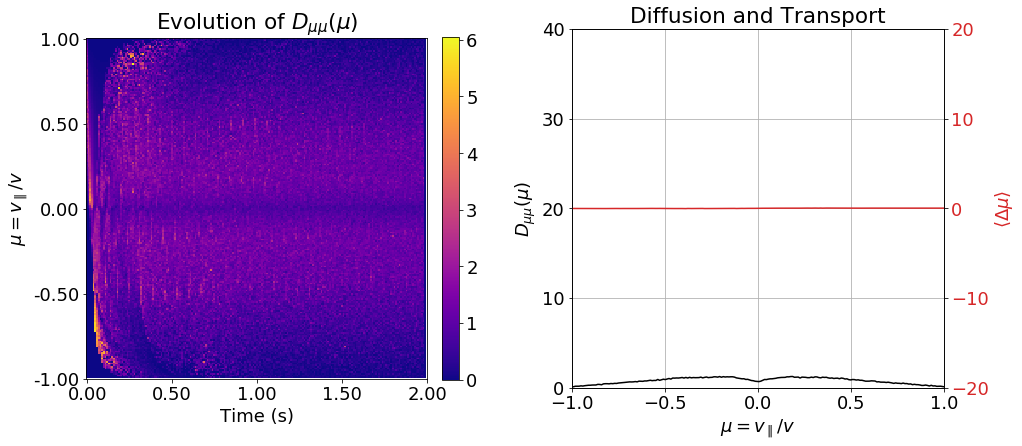

In [9]:
D_uu_evolution(system.history, 200, 200, 2, 1e-3)

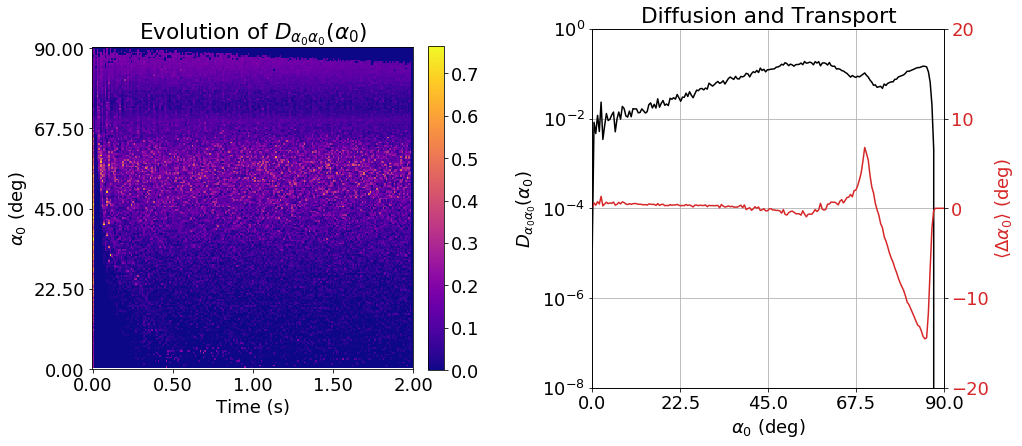

In [10]:
D_mumu_evolution(system.history, 200, 200, 2, 1e-3)

In [11]:
system.load("5000_12Re_2MeV_20pa")

Loaded files containing 916.10 megabytes of information.


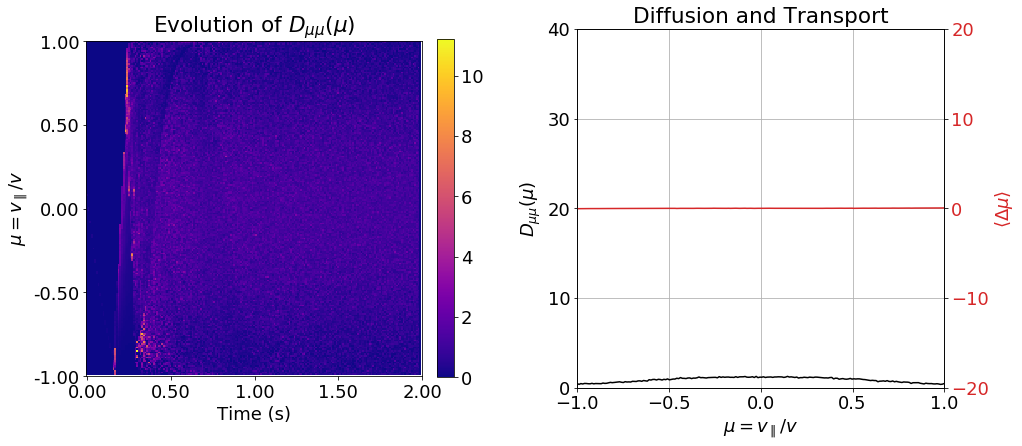

In [12]:
D_uu_evolution(system.history, 200, 200, 2, 1e-3)

The below plot is very nice: it matches quite well with Artemyev's analytical results from his 2013 paper (see Figure 2).

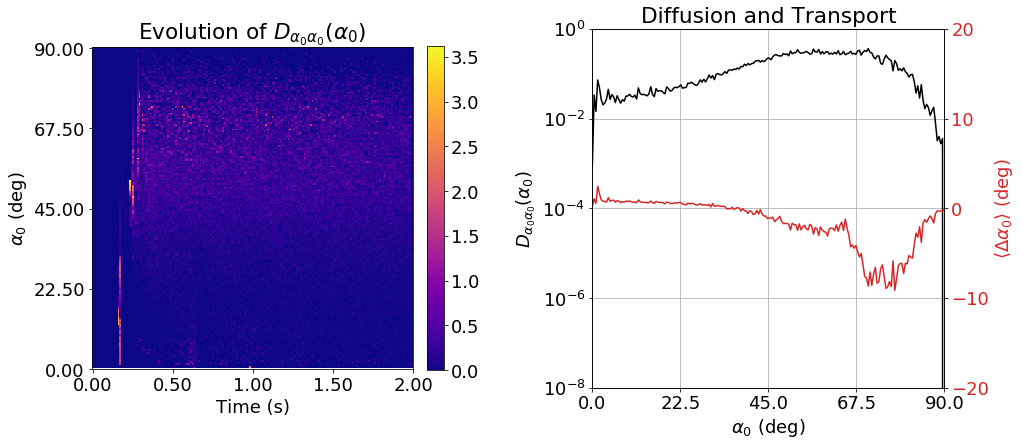

In [13]:
D_mumu_evolution(system.history, 200, 200, 2, 1e-3)

In [14]:
system.load("5000_5Re_1MeV_20pa")

Loaded files containing 916.10 megabytes of information.


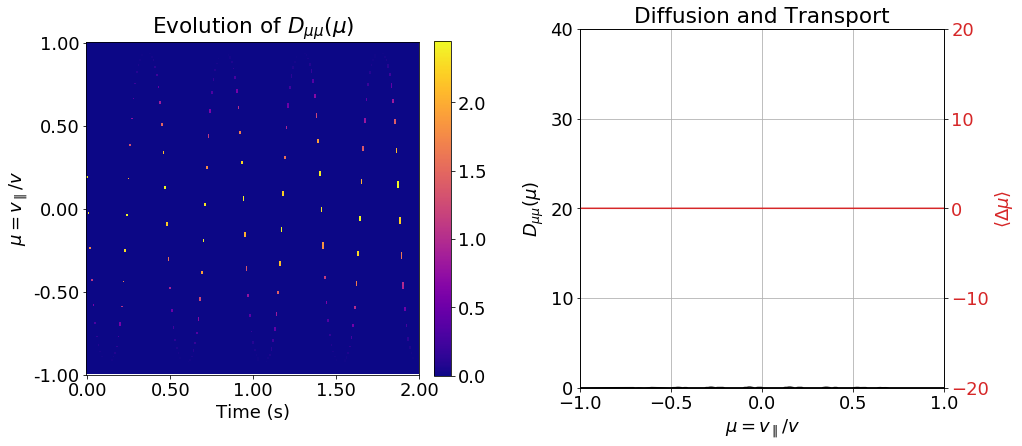

In [15]:
D_uu_evolution(system.history, 200, 200, 2, 1e-3)

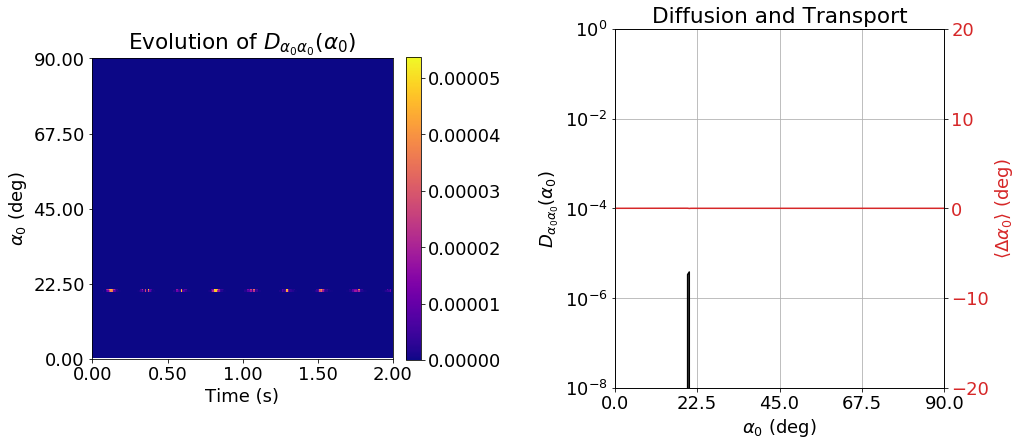

In [16]:
D_mumu_evolution(system.history, 200, 200, 2, 1e-3)

The below is an attempt to calculate the diffusion coefficient following method MIIb in https://arxiv.org/pdf/1610.03240.pdf (as opposed to method MI which we use above). The current sample size ($\approx 10^4$ particles) is too small to reliably use MIIb. In particular, the derivative operations produce too much noise.

In [17]:
@njit
def mus(history):
    num_particles = len(history[:, 0, 0, 0])
    steps = len(history[0, :, 0, 0])
    
    history_new = np.zeros((num_particles, steps))
    
    for i in range(num_particles):
        for j in range(steps):
            v_par = dot(history[i, j, 1, :], history[i, j, 2, :]) / np.linalg.norm(history[i, j, 2, :])
            v     = np.linalg.norm(history[i, j, 1, :])
            history_new[i, j] = v_par / v
            
    return history_new

In [291]:
def dist_func(t, mus):
    t_ind = floor(t / 1e-3)
    f, x = np.histogram(mus[:, t_ind], bins=np.linspace(-1, 1, 200), density=True)
    coeffs = np.polynomial.legendre.legfit((x[1:] + x[:-1]) / 2, f, 10)
    return lambda x0: np.polynomial.legendre.legval(x0, coeffs)

In [292]:
mu_val = mus(system.history)
fs = []

steps = len(system.history[0, :, 0, 0])

for i in tqdm.tqdm(range(steps)):
    fs.append(dist_func(i * 1e-3, mu_val))

100%|██████████| 2000/2000 [00:01<00:00, 1515.46it/s]


In [293]:
def D_uu(t, mu, fs):
    dt  = 1e-3
    du = (1 - -1) / 50
    t_ind = floor(t / dt)
    
    int_dfdt = np.sum((fs[t_ind + 1](np.arange(-1, mu, du)) - fs[t_ind](np.arange(-1, mu, du))) / dt)
    dfdu = (fs[t_ind](mu + du) - fs[t_ind](mu)) / du
    
    return int_dfdt / dfdu

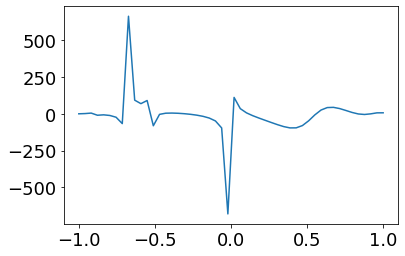

In [294]:
xs = np.linspace(-1, 1, 50)
ys = [D_uu(0.5, x, fs) for x in xs]

plt.plot(xs, ys)

In [12]:
a = np.zeros((3, 4))

In [15]:
for i in range(3):
    for j in range(4):
        a[i, j] = (i + 1) * (j + 1)

In [18]:
np.mean(a, axis=1)

array([2.5, 5. , 7.5])